### Unit 3 HW: Quantum Noise

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# PHYSICAL CONSTANTS & PARAMETERS
# -----------------------------------------------------------------------------
Dx = 1e-10              # Spatial step (1 Angstrom)
L_device = 2e-8         # Simulation Box length
m = 0.063 * 9.109e-31   # Effective electron mass (kg)
h_bar = 1.054e-34       # Reduced Planck constant (J·s)
qe = 1.6e-19            # Electron charge (C)
Kb = 1.38e-23           # Boltzmann constant (J/K)
T = 298                 # Temperature (K)
Ef = 0.1                # Fermi energy (eV)

# Theoretical Landauer conductance G0
G0 = qe**2 / (np.pi * h_bar)


In [44]:
# -----------------------------------------------------------------------------
# HELPER FUNCTIONS
# -----------------------------------------------------------------------------

def get_transmission(Energy, Potential):
    """
    Calculates Transmission T(E) using the Numerov Method for a given Potential profile.
    From HW3: RTD simulation

    Inputs:
    :Energy: Energy values (in eV)
    :Potential: Potential Energy V(x) (in Joules) 
    """
    N_points = len(Potential)
    x = np.arange(1, N_points + 1) * Dx

    T_prob = np.zeros(len(Energy))
    
    # Numerov Constants (for Equation 1)
    A = (10 * Dx**2) / 12
    AA = Dx**2 / 12
    const_factor = (2 * m) / h_bar**2

    for i, E in enumerate(Energy):
        E_joule = E * qe
        
        # We ensure E > U at boundaries (leads) to avoid k being imaginary
        if E_joule <= Potential[0] or E_joule <= Potential[-1]:
            T_prob[i] = 0.0
            continue

        # Wavevectors in extremes (scattering states): k = sqrt(2m(E-V)) / h_bar
        k_left = np.sqrt(const_factor * (E_joule - Potential[0]))
        k_right = np.sqrt(const_factor * (E_joule - Potential[-1]))

        # Numerov Function: f(x) = 2m/h^2 * (V(x) - E)
        # Equation to be solved: psi'' = f(x)psi.
        func_numerov = const_factor * (Potential - E_joule)

        # Initialize Wavefunction (first two points at right boundary)
        # We assume outgoing plane waves on the right are prop. to exp(i * k_right * x) (scattering state)
        # This is the same as assuming a wave has successfully transmited to the right side
        psi = np.zeros(N_points, dtype=complex)
        psi[-1] = np.exp(1j * k_right * x[-1])
        psi[-2] = np.exp(1j * k_right * x[-2])

        # Backward Integration from Right to Left (Equation 1)
        for j in range(N_points - 3, -1, -1):
            term1 = (2 + A * func_numerov[j+1]) * psi[j+1]
            term2 = (1 - AA * func_numerov[j+2]) * psi[j+2]
            denom = (1 - AA * func_numerov[j])
            psi[j] = (term1 - term2) / denom

        # Now let's match boundary conditions at the left side:
        # Psi_left = A * exp(ikx) + B * exp(-ikx)
        # We want T = (k_right / k_left) * |Amplitude_Transmitted|^2 / |Amplitude_Incident|^2
        #           = (k_right / k_left) * (1 / |A|^2)
        # We need to isolate A. We do it using Psi_left and Psi'_Left = ik * A * exp(ikx) -ik * B * exp(-ikx)
        # Knowing Psi and Psi', we have two unkowns A and B --> A = ... = (1/2) exp(-ikx) (Psi(x) + Psi'(x) / (ik))
        
        # First, we get numerical values for psi and psi' in a safe point (not at the edges)
        idx_match = 5
        psi_val = psi[idx_match]
        # Finite difference derivative: dpsi/dx
        d_psi = (psi[idx_match+1] - psi[idx_match]) / Dx 
        
        # Second, we get the incident amplitude with the derived formula above:
        A_inc = 0.5 * np.exp(-1j * k_left * x[idx_match]) * (psi_val + d_psi / (1j * k_left))
        
        if np.abs(A_inc) == 0:
            T_prob[i] = 0
        else:
            T_prob[i] = (k_right / k_left) / (np.abs(A_inc)**2)
            
    return T_prob

def compute_current(Voltages, Energies, U_base, T):
    """
    Computes Mean Current (I) for a given potential profile U_base and temperature T.
    """
    Currents = np.zeros(len(Voltages))
    
    # Define active region indices
    N_pts = len(U_base)
    start_active = int(0.25 * N_pts)
    end_active = int(0.75 * N_pts)
    points_active = end_active - start_active
    # Linear slope drop:
    points_slope = np.arange(points_active)
    fraction = (points_slope / points_active)
    
    for i, Vb in enumerate(Voltages):
        # 1. Tilt potential
        U_bias = U_base.copy()
        
        # Right reservoir drops by Vb
        U_bias[end_active:] = U_bias[end_active:] - (Vb * qe)
        
        # Voltage drop across active region
        voltage_drop = (Vb * qe) * fraction
        U_bias[start_active:end_active] -= voltage_drop
        
        # 2. Compute T(E, V)
        Trans = get_transmission(Energies, U_bias)
        
        # 3. Compute Current Integral
        mu_L = Ef
        mu_R = Ef - Vb
        
        # LOW TEMPERATURE (step function approx)
        if T < 1e-6:
            # At T~0, Fermi-Dirac becomes a step function 
            # s.t. f_L (f_R) = 1 for E < mu_L (mu_R) and 0 otherwise
            # Current is integral of T(E) between mu_R and mu_L
            # Find indices where E is between mu_R and mu_L
            idx_window = np.where((Energies >= mu_R) & (Energies <= mu_L))[0]
            if len(idx_window) > 0:
                integral = np.trapezoid(Trans[idx_window], Energies[idx_window] * qe)
            else:
                integral = 0

        # FINITE TEMPERATURE
        else:
            arg_L = (Energies - mu_L) * qe / (Kb * T)
            arg_R = (Energies - mu_R) * qe / (Kb * T)
            
            # Fermi Functions
            fL = 1.0 / (1.0 + np.exp(arg_L))
            fR = 1.0 / (1.0 + np.exp(arg_R))
            
            integrand = Trans * (fL - fR)
            integral = np.trapezoid(integrand, Energies * qe)
        
        # I = (e / pi hbar) * Integral
        Currents[i] = (qe / (np.pi * h_bar)) * integral

    return Currents

Simulating Case 1: T -> 0 K, No Barrier...


C:\Users\jmarq\AppData\Local\Temp\ipykernel_22028\1181288271.py:128: RuntimeWarning: overflow encountered in exp
  fL = 1.0 / (1.0 + np.exp(arg_L))
C:\Users\jmarq\AppData\Local\Temp\ipykernel_22028\1181288271.py:129: RuntimeWarning: overflow encountered in exp
  fR = 1.0 / (1.0 + np.exp(arg_R))


Simulating Case 2: T -> 0 K, One Barrier...
Simulating Case 3: T = 300 K, No Barrier...


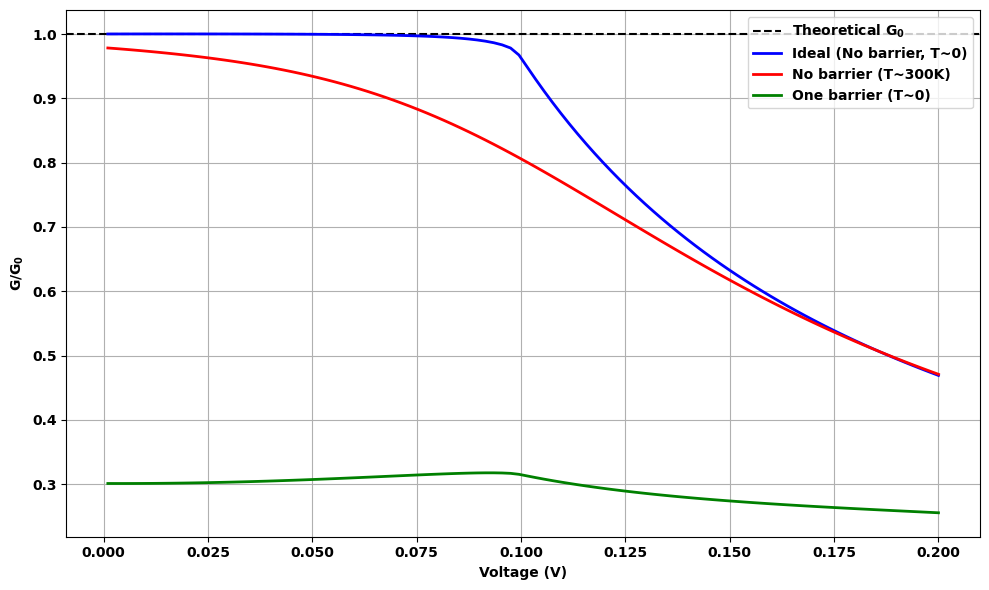

In [15]:
# -----------------------------------------------------------------------------
# PART 1: LANDAUER CONDUCTANCE
# -----------------------------------------------------------------------------

# Set up (perfect wire, no barrier)
xpoints = int(np.floor(L_device / Dx))
U_wire = np.zeros(xpoints) # Flat potential V=0 everywhere

# Energy Grid
E_max = 0.5
E_steps = 1000
Energies = np.linspace(0.001, E_max, E_steps)

# Voltage Sweep
V_max = 0.2 
V_steps = 100
Voltages = np.linspace(0.001, V_max, V_steps) # Avoid dividing by zero

# Case 1: Ideal Case (T -> 0 K, No Barrier)
print("Simulating Case 1: T -> 0 K, No Barrier...")
I_ideal = compute_current(Voltages, Energies, U_wire, T=5)
G_ideal = I_ideal / Voltages

# Case 2: One Barrier (T -> 0 K, 0.3 eV)
print("Simulating Case 2: T -> 0 K, One Barrier...")
# Define a small barrier
U_barrier = np.zeros(xpoints)
center = xpoints // 2
width = int(2e-9 / Dx)
U_barrier[center - width//2 : center + width//2] = 0.3 * qe

I_bar = compute_current(Voltages, Energies, U_barrier, T=5)
G_bar = I_bar / Voltages

# Case 3: Room Temperature (T = 300 K, No Barrier)
print("Simulating Case 3: T = 300 K, No Barrier...")
I_room = compute_current(Voltages, Energies, U_wire, T=300)
G_room = I_room / Voltages

# Case 4: Room Temperature + Barrier (T = 300 K, One Barrier)
#print("Simulating Case 4: T = 300 K, One Barrier...")
#I_roombar = compute_current(Voltages, Energies, U_barrier, T=300)
#G_roombar = I_roombar / Voltages


# Plot G/G0 vs Voltage
plt.figure(figsize=(10, 6))
plt.axhline(y=1.0, color='k', linestyle='--', label='Theoretical $G_0$')
plt.plot(Voltages, G_ideal / G0, 'b-', lw=2, label='Ideal (No barrier, T~0)')
plt.plot(Voltages, G_room / G0, 'r-', lw=2, label='No barrier (T~300K)')
plt.plot(Voltages, G_bar / G0, 'g-', lw=2, label='One barrier (T~0)')
#plt.plot(Voltages, G_roombar / G0, 'm-', label='One Barrier (T~298K)')


plt.xlabel('Voltage (V)')
plt.ylabel(r'$G/G_0$')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------------------------------------------------------
# HELPER FUNCTIONS
# -----------------------------------------------------------------------------

def compute_noise(Voltages, Energies, U_base, T):
    """
    Computes Noise Power Spectral Density S(0) 
    for a given potential profile U_base and temperature T.
    """
    Noise_S = np.zeros(len(Voltages))
    
    # Define active region indices
    N_pts = len(U_base)
    start_active = int(0.25 * N_pts)
    end_active = int(0.75 * N_pts)
    points_active = end_active - start_active
    points_slope = np.arange(points_active)
    fraction = (points_slope / points_active)
    
    for i, Vb in enumerate(Voltages):
        # 1. Tilt potential
        U_bias = U_base.copy()
        # Right reservoir drops by Vb
        U_bias[end_active:] = U_bias[end_active:] - (Vb * qe)
        # Voltage drop across active region
        voltage_drop = (Vb * qe) * fraction
        U_bias[start_active:end_active] -= voltage_drop
        
        # 2. Compute T(E, V)
        Trans = get_transmission(Energies, U_bias)
        
        # 3. Compute Noise Integral
        # Integrand: T * [fL(1-fR) + fR(1-fL)] - T^2 * (fL - fR)^2
        mu_L = Ef
        mu_R = Ef - Vb
        
        # LOW TEMPERATURE (step function approx)
        if T < 1e-6:
            idx_window = np.where((Energies >= mu_R) & (Energies <= mu_L))[0]
            if len(idx_window) > 0:
                # Noise Integrand: T * (1 - T)
                integrand =Trans[idx_window] * (1 - Trans[idx_window])
                integral = np.trapezoid(integrand, Energies[idx_window] * qe)
            else:
                integral = 0
        # FINITE TEMPERATURE
        else:
            arg_L = (Energies - mu_L) * qe / (Kb * T)
            arg_R = (Energies - mu_R) * qe / (Kb * T)
            
            # Fermi Functions
            fL = 1.0 / (1.0 + np.exp(arg_L))
            fR = 1.0 / (1.0 + np.exp(arg_R))
            
            # Noise Integrand
            integrand = Trans * (fL * (1 - fR) + fR * (1 - fL)) - Trans**2 * (fL - fR)**2
            integral = np.trapezoid(integrand, Energies * qe)
        
        # S = (2e^2 / pi hbar) * Integral
        Noise_S[i] = (2.0 * qe**2 / (np.pi * h_bar)) * integral

    return Noise_S

In [39]:
# -----------------------------------------------------------------------------
# PART 2: FANO FACTOR AND EQUILIBRIUM NOISE
# -----------------------------------------------------------------------------

# Define Double Barrier Potential (0.4 eV, 2nm wide, 5nm apart)
xpoints = int(np.floor(L_device / Dx))
U_double = np.zeros(xpoints)
b_width = int(2e-9 / Dx)
well_width = int(4e-9 / Dx) 
center = xpoints // 2

# Two barriers
U_double[center - well_width//2 - b_width : center - well_width//2] = 0.4 * qe
U_double[center + well_width//2 : center + well_width//2 + b_width] = 0.4 * qe

# Run Simulations
V_sweep = np.linspace(0.001, 0.4, 200)
E_grid = np.linspace(0.001, 0.6, 500)

print("\nSimulating Double Barrier: T = 300 K")
I_300 = compute_current(V_sweep, E_grid, U_double, T=300)
S_300 = compute_noise(V_sweep, E_grid, U_double, T=300)

print("\nSimulating Double Barrier: T = 5 K")
I_5 = compute_current(V_sweep, E_grid, U_double, T=5)
S_5 = compute_noise(V_sweep, E_grid, U_double, T=5)

# Fano Factor F = S / (2eI)
F_300 = S_300 / (2 * qe * I_300)
F_5 = S_5 / (2 * qe * I_5)



Simulating Double Barrier: T = 300 K

Simulating Double Barrier: T = 5 K


C:\Users\jmarq\AppData\Local\Temp\ipykernel_22028\1181288271.py:128: RuntimeWarning: overflow encountered in exp
  fL = 1.0 / (1.0 + np.exp(arg_L))
C:\Users\jmarq\AppData\Local\Temp\ipykernel_22028\1181288271.py:129: RuntimeWarning: overflow encountered in exp
  fR = 1.0 / (1.0 + np.exp(arg_R))
C:\Users\jmarq\AppData\Local\Temp\ipykernel_22028\3399479477.py:52: RuntimeWarning: overflow encountered in exp
  fL = 1.0 / (1.0 + np.exp(arg_L))
C:\Users\jmarq\AppData\Local\Temp\ipykernel_22028\3399479477.py:53: RuntimeWarning: overflow encountered in exp
  fR = 1.0 / (1.0 + np.exp(arg_R))


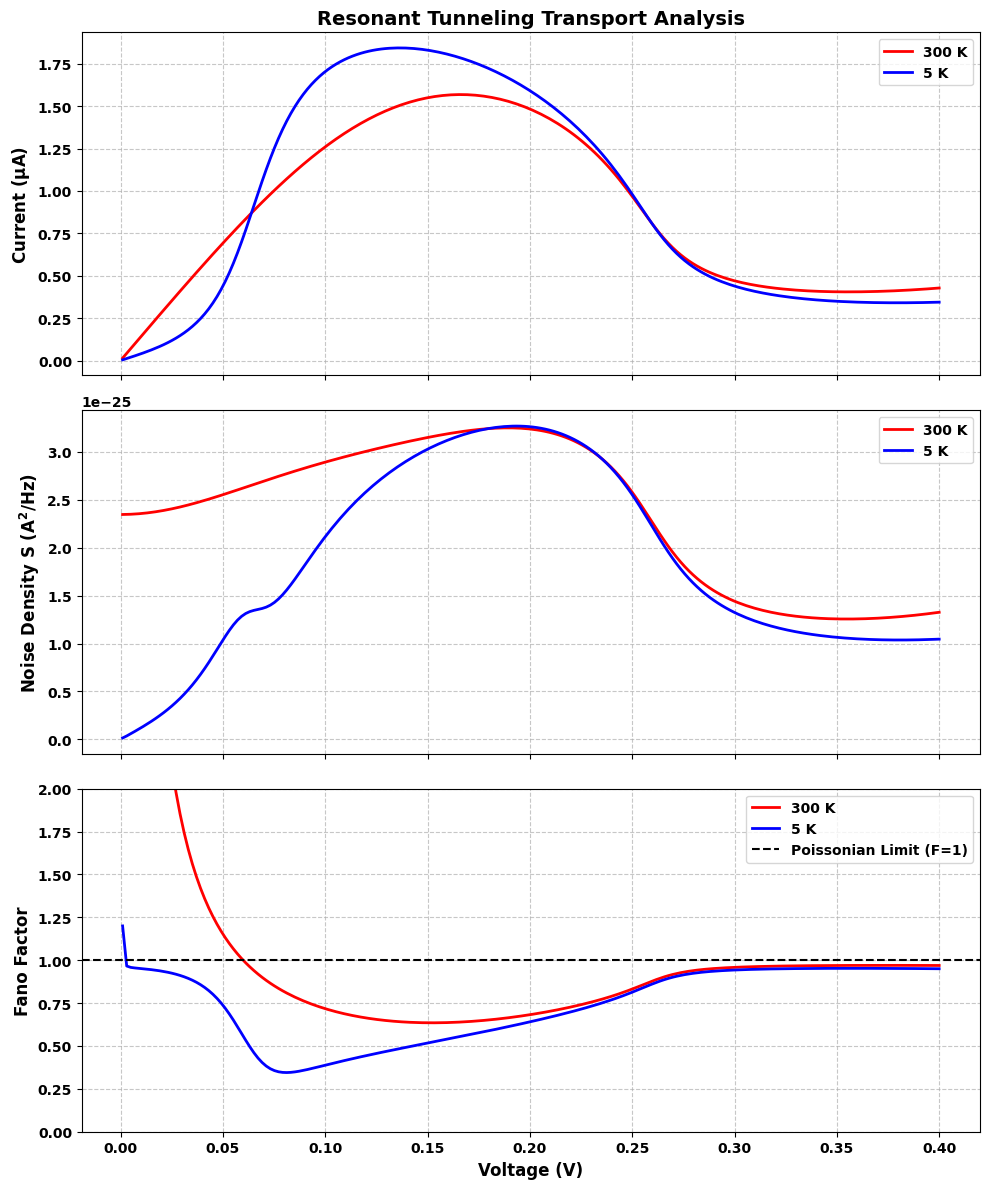

In [47]:
# PLOTTING: IV CURVE, NOISE, AND FANO FACTOR

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Plot 1: I-V Characteristic
ax1.plot(V_sweep, I_300 * 1e6, 'r-', linewidth=2, label='300 K')
ax1.plot(V_sweep, I_5 * 1e6, 'b-', linewidth=2, label='5 K')
ax1.set_ylabel(r'Current ($\mu$A)', fontsize=12)
ax1.set_title('Resonant Tunneling Transport Analysis', fontsize=14)
ax1.legend(loc='upper right')
ax1.grid(True, linestyle='--', alpha=0.7)

# Plot 2: Noise Power S(V)
ax2.plot(V_sweep, S_300, 'r-', linewidth=2, label='300 K')
ax2.plot(V_sweep, S_5, 'b-', linewidth=2, label='5 K')
ax2.set_ylabel(r'Noise Density $S$ ($A^2/Hz$)', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True, linestyle='--', alpha=0.7)

# Plot 3: Fano Factor
ax3.plot(V_sweep, F_300, 'r-', linewidth=2, label='300 K')
ax3.plot(V_sweep, F_5, 'b-', linewidth=2, label='5 K')
# reference line for Poissonian Noise (F=1):
ax3.axhline(y=1.0, color='k', linestyle='--', linewidth=1.5, label='Poissonian Limit (F=1)')

ax3.set_ylabel(r'Fano Factor', fontsize=12)
ax3.set_xlabel('Voltage (V)', fontsize=12)
ax3.set_ylim(0, 2.0) 
ax3.legend(loc='upper right')
ax3.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [57]:
# EXERCISE 5.3. FLUCTUATION-DISSIPATION THEOREM
xpoints = int(np.floor(L_device / Dx))
U_wire = np.zeros(xpoints) 
U_double = U_double

V_fdt = np.linspace(0.0001, 0.1, 50)
E_grid = np.linspace(0.001, 0.6, 500)

T_low = 5.0
T_room = 300

# CASE A: No Barrier, 5 K
I_A = compute_current(V_fdt, E_grid, U_wire, T_low)
S_A = compute_noise(V_fdt, E_grid, U_wire, T_low)
G_A = I_A / V_fdt
S_th_A = 4 * Kb * T_low * G_A

# CASE B: No Barrier, 300 K
I_B = compute_current(V_fdt, E_grid, U_wire, T_room)
S_B = compute_noise(V_fdt, E_grid, U_wire, T_room)
G_B = I_B / V_fdt
S_th_B = 4 * Kb * T_room * G_B

# CASE C: Double Barrier, 5 K
I_C = compute_current(V_fdt, E_grid, U_barrier, T_low)
S_C = compute_noise(V_fdt, E_grid, U_barrier, T_low)
G_C = I_C / V_fdt
S_th_C = 4 * Kb * T_low * G_C


C:\Users\jmarq\AppData\Local\Temp\ipykernel_22028\1181288271.py:128: RuntimeWarning: overflow encountered in exp
  fL = 1.0 / (1.0 + np.exp(arg_L))
C:\Users\jmarq\AppData\Local\Temp\ipykernel_22028\1181288271.py:129: RuntimeWarning: overflow encountered in exp
  fR = 1.0 / (1.0 + np.exp(arg_R))
C:\Users\jmarq\AppData\Local\Temp\ipykernel_22028\3399479477.py:52: RuntimeWarning: overflow encountered in exp
  fL = 1.0 / (1.0 + np.exp(arg_L))
C:\Users\jmarq\AppData\Local\Temp\ipykernel_22028\3399479477.py:53: RuntimeWarning: overflow encountered in exp
  fR = 1.0 / (1.0 + np.exp(arg_R))


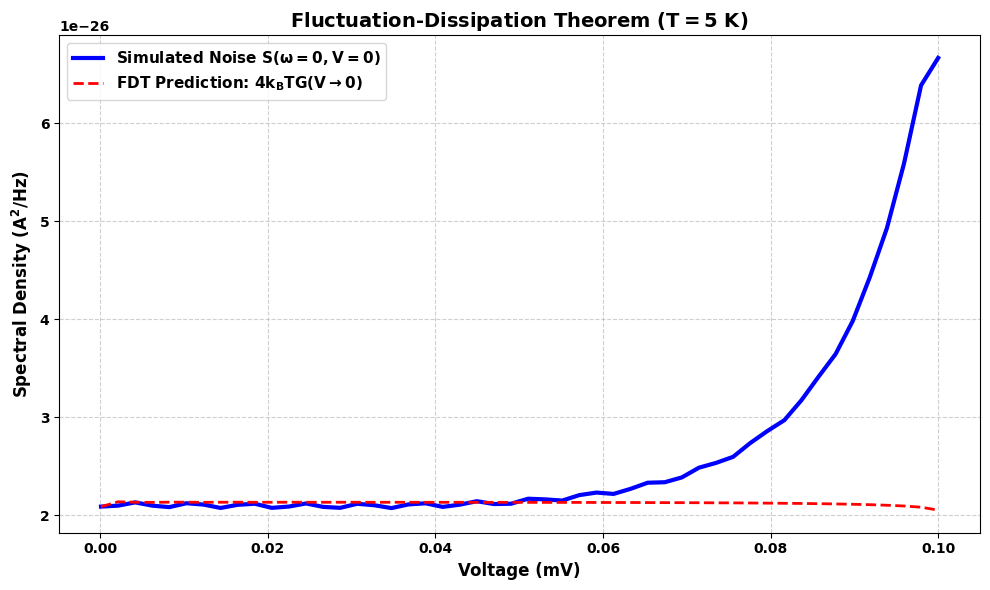

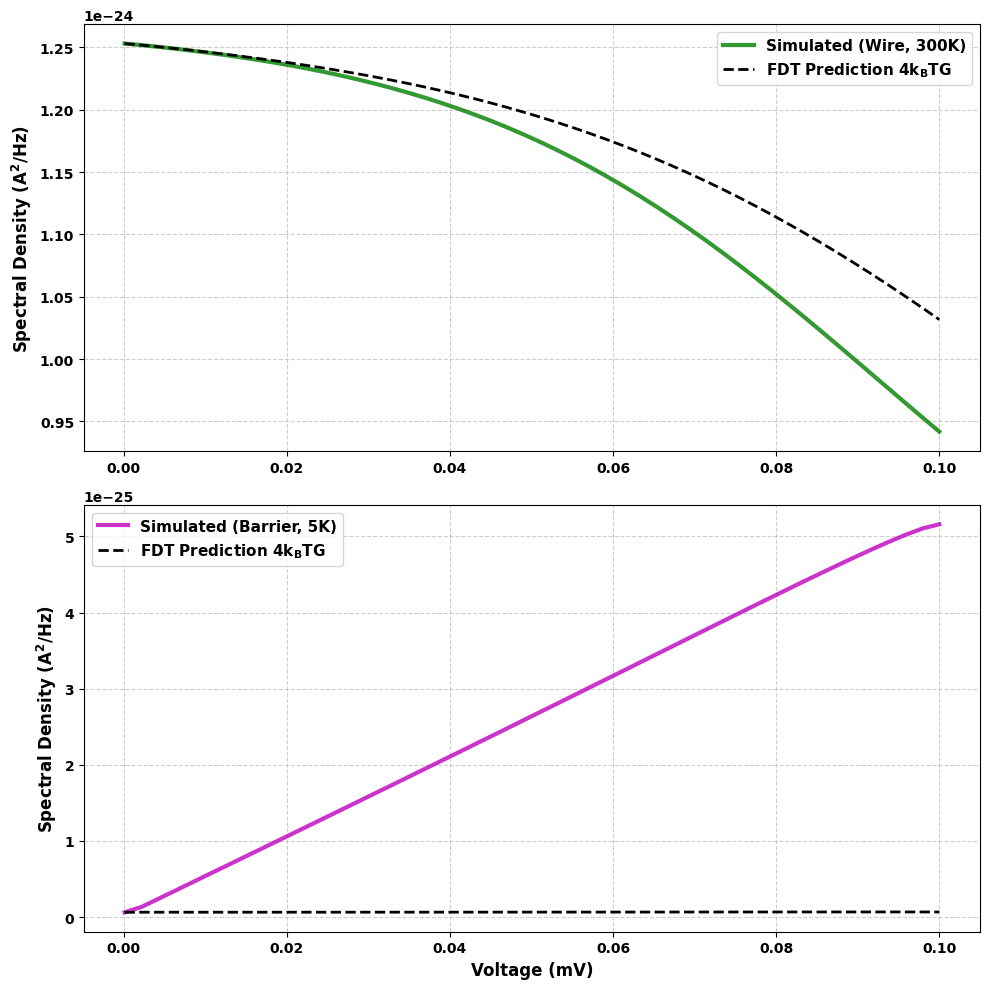

Convergence Ratio (Wire, 5K):   1.0005
Convergence Ratio (Wire, 300K): 1.0000
Convergence Ratio (Barrier):    1.0033


In [58]:
# Plotting
# PLOT CASE A:
plt.figure(figsize=(10, 6))

# Simulated Noise
plt.plot(V_fdt, S_A, 'b-', lw=3, label=r'Simulated Noise $S(\omega=0, V=0)$')
# Theoretical Prediction (4kTG)
plt.plot(V_fdt, S_th_A, 'r--', linewidth=2, label=r'FDT Prediction: $4 k_B T G(V \rightarrow 0)$')

plt.title(r'Fluctuation-Dissipation Theorem ($T=5$ K)', fontsize=14)
plt.xlabel('Voltage (mV)', fontsize=12)
plt.ylabel(r'Spectral Density ($A^2/Hz$)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, which='both', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# PLOT CASE B:
ax1.plot(V_fdt, S_B, 'g-', lw=3, alpha=0.8, label=r'Simulated (Wire, 300K)')
ax1.plot(V_fdt, S_th_B, 'k--', lw=2, label=r'FDT Prediction $4k_BTG$')

ax1.set_ylabel(r'Spectral Density ($A^2/Hz$)', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, linestyle='--', alpha=0.6)

# PLOT CASE C:
ax2.plot(V_fdt, S_C, 'm-', lw=3, alpha=0.8, label=r'Simulated (Barrier, 5K)')
ax2.plot(V_fdt, S_th_C, 'k--', lw=2, label=r'FDT Prediction $4k_BTG$')

ax2.set_xlabel('Voltage (mV)', fontsize=12)
ax2.set_ylabel(r'Spectral Density ($A^2/Hz$)', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Convergence Check
print(f"Convergence Ratio (Wire, 5K):   {S_A[0]/S_th_A[0]:.4f}")
print(f"Convergence Ratio (Wire, 300K): {S_B[0]/S_th_B[0]:.4f}")
print(f"Convergence Ratio (Barrier):    {S_C[0]/S_th_C[0]:.4f}")
